# Analiza danych i generowanie widoków wsadowych w Apache Spark 

In [224]:
import findspark
findspark.init()

import happybase
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objs as go

from pyspark.sql import SparkSession
from pyspark.sql.functions import date_trunc, min, max, mean, col, to_timestamp, expr, dayofyear, stddev
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType

In [119]:
spark = (
    SparkSession.builder
    .master("local")
    .appName("bigdataproject")
    .enableHiveSupport()
    .getOrCreate()
)

spark.sparkContext.setLogLevel("ERROR")

## Przedstawienie źródeł danych

### Niezagregowane dane GEFS z Apache Hive

In [54]:
spark.sql("select * from gefs where time is not null;").show(n=10)

+--------+---------+-------------------+-------------------+-----+-----+
|latitude|longitude|               time|         valid_time|  u10|  v10|
+--------+---------+-------------------+-------------------+-----+-----+
|    45.0|      5.0|2023-11-24 00:00:00|2023-12-01 00:00:00| 0.25| 1.71|
|    45.0|      5.5|2023-11-24 00:00:00|2023-12-01 00:00:00|-1.06| 1.77|
|    45.0|      6.0|2023-11-24 00:00:00|2023-12-01 00:00:00| -1.0| 2.34|
|    45.0|      6.5|2023-11-24 00:00:00|2023-12-01 00:00:00| 0.37| 2.29|
|    45.0|      7.0|2023-11-24 00:00:00|2023-12-01 00:00:00| 0.53| 0.37|
|    45.0|      7.5|2023-11-24 00:00:00|2023-12-01 00:00:00| 0.26|-0.64|
|    45.0|      8.0|2023-11-24 00:00:00|2023-12-01 00:00:00| 0.41| -0.7|
|    45.0|      8.5|2023-11-24 00:00:00|2023-12-01 00:00:00| 0.26|-1.45|
|    45.0|      9.0|2023-11-24 00:00:00|2023-12-01 00:00:00|-0.61| -1.2|
|    45.0|      9.5|2023-11-24 00:00:00|2023-12-01 00:00:00| -1.2|-0.68|
+--------+---------+-------------------+-----------

### Zagregowane dane GEFS z Apache HBase

In [190]:
connection = happybase.Connection("localhost")

table = connection.table('gefs_agg')
table.row(b"20231201")

{b'agg:u10_avg_north': b'-1.4940259740259734',
 b'agg:u10_avg_south': b'-0.22376190476190475',
 b'agg:u10_avg_total': b'-0.8891383219954643',
 b'agg:v10_avg_north': b'1.9530735930735934',
 b'agg:v10_avg_south': b'1.195142857142857',
 b'agg:v10_avg_total': b'1.5921541950113374'}

### Dane opisujące ceny energii z HDFS

In [38]:
prices_directory_path = f"/user/bigdataproject/germany_prices/prices__2024-01-08 22*"
fs = spark._jsc.hadoopConfiguration()
path = spark._jvm.org.apache.hadoop.fs.Path(prices_directory_path)
fs = path.getFileSystem(spark._jsc.hadoopConfiguration())
status = fs.globStatus(path)
file_paths = [file.getPath().toString() for file in status]

schema = StructType([
    StructField("position", IntegerType(), True),
    StructField("price_amount", FloatType(), True),
    StructField("start_date", StringType(), True),
    StructField("row_id", StringType(), True),
    StructField("end_date", StringType(), True),
    StructField("publication_date", StringType(), True)
])
prices_da = spark.createDataFrame([], schema)

for directory in file_paths:
    df = spark.read.parquet(directory)
    df = df.withColumn("price_amount", df["price_amount"].cast("float"))
    prices_da = prices_da.unionByName(df, allowMissingColumns=True)

prices_da.show(n=10)

+--------+------------+-----------------+--------------------+-----------------+----------------+
|position|price_amount|       start_date|              row_id|         end_date|publication_date|
+--------+------------+-----------------+--------------------+-----------------+----------------+
|       1|      106.91|2023-11-30T23:00Z| 1_2023-11-30T23:00Z|2023-12-01T23:00Z|   2024-01-08 22|
|       3|        99.1|2023-11-30T23:00Z| 3_2023-11-30T23:00Z|2023-12-01T23:00Z|   2024-01-08 22|
|       5|       96.07|2023-11-30T23:00Z| 5_2023-11-30T23:00Z|2023-12-01T23:00Z|   2024-01-08 22|
|      19|      199.16|2023-11-30T23:00Z|19_2023-11-30T23:00Z|2023-12-01T23:00Z|   2024-01-08 22|
|      20|      168.56|2023-11-30T23:00Z|20_2023-11-30T23:00Z|2023-12-01T23:00Z|   2024-01-08 22|
|       7|      120.03|2023-11-30T23:00Z| 7_2023-11-30T23:00Z|2023-12-01T23:00Z|   2024-01-08 22|
|      10|      222.63|2023-11-30T23:00Z|10_2023-11-30T23:00Z|2023-12-01T23:00Z|   2024-01-08 22|
|      13|      197.

### Dane opisujące produkcję energii wiatrowej z HDFS

In [39]:
prices_directory_path = f"/user/bigdataproject/windOffshore/wind__2024-01-08 21*.parquet"
fs = spark._jsc.hadoopConfiguration()
path = spark._jvm.org.apache.hadoop.fs.Path(prices_directory_path)
fs = path.getFileSystem(spark._jsc.hadoopConfiguration())
status = fs.globStatus(path)
file_paths = [file.getPath().toString() for file in status]

schema = StructType([
    StructField("position", IntegerType(), True),
    StructField("quantity", FloatType(), True),
    StructField("start_date", StringType(), True),
    StructField("row_id", StringType(), True),
    StructField("end_date", StringType(), True),
    StructField("publication_date", StringType(), True)
])
wind_data = spark.createDataFrame([], schema)

for directory in file_paths:
    df = spark.read.parquet(directory)
    df = df.withColumn("quantity", df["quantity"].cast("float"))
    wind_data = wind_data.unionByName(df, allowMissingColumns=True)
    
wind_data.show(n=10)

+--------+--------+-----------------+--------------------+-----------------+----------------+
|position|quantity|       start_date|              row_id|         end_date|publication_date|
+--------+--------+-----------------+--------------------+-----------------+----------------+
|      42|  4418.0|2023-12-11T23:00Z|42_2023-12-12T23:00Z|2023-12-12T23:00Z|   2024-01-08 21|
|       1| 17153.0|2023-12-11T23:00Z| 1_2023-12-12T23:00Z|2023-12-12T23:00Z|   2024-01-08 21|
|      43|  4327.0|2023-12-11T23:00Z|43_2023-12-12T23:00Z|2023-12-12T23:00Z|   2024-01-08 21|
|       2| 16647.0|2023-12-11T23:00Z| 2_2023-12-12T23:00Z|2023-12-12T23:00Z|   2024-01-08 21|
|      44|  4231.0|2023-12-11T23:00Z|44_2023-12-12T23:00Z|2023-12-12T23:00Z|   2024-01-08 21|
|       3| 16141.0|2023-12-11T23:00Z| 3_2023-12-12T23:00Z|2023-12-12T23:00Z|   2024-01-08 21|
|       4| 15627.0|2023-12-11T23:00Z| 4_2023-12-12T23:00Z|2023-12-12T23:00Z|   2024-01-08 21|
|      45|  4145.0|2023-12-11T23:00Z|45_2023-12-12T23:00Z|20

## Analiza danych

In [47]:
# drobne przekształcenia

prices_df = prices_da.withColumn('start_date', to_timestamp('start_date', "yyyy-MM-dd'T'HH:mm'Z'"))
prices_df = prices_df.withColumn('position', col('position').cast('integer'))
prices_df = prices_df.withColumn('actual_datetime', expr("start_date + INTERVAL 1 HOURS * (position - 1) HOURS"))

wind_df = wind_data.withColumn('start_date', to_timestamp('start_date', "yyyy-MM-dd'T'HH:mm'Z'"))
wind_df = wind_df.withColumn('position', col('position').cast('integer'))
wind_df = wind_df.withColumn('actual_datetime', expr("start_date + INTERVAL 15 MINUTES * (position - 1)"))

#### Wykres - maksymalna i minimalna cena energii w ciągu dnia

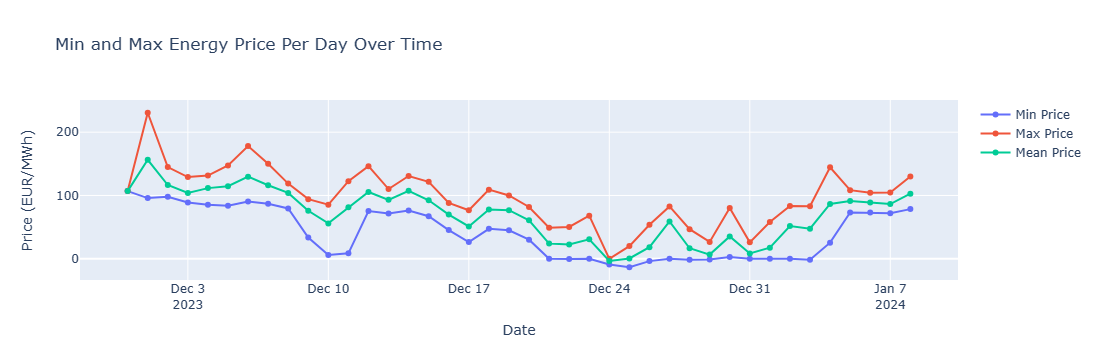

In [44]:
price_stats_df = (
    prices_df.groupBy(date_trunc("day", "actual_datetime").alias("date"))
    .agg(
        min("price_amount").alias("min_price"),
        max("price_amount").alias("max_price"),
        mean("price_amount").alias("mean_price"),
    )
    .orderBy("date")
)

collected_stats = price_stats_df.collect()
dates = [row["date"] for row in collected_stats]
min_prices = [row["min_price"] for row in collected_stats]
max_prices = [row["max_price"] for row in collected_stats]
mean_prices = [row["mean_price"] for row in collected_stats]
trace_min = go.Scatter(x=dates, y=min_prices, mode="markers+lines", name="Min Price")
trace_max = go.Scatter(x=dates, y=max_prices, mode="markers+lines", name="Max Price")
trace_mean = go.Scatter(x=dates, y=mean_prices, mode="markers+lines", name="Mean Price")

layout = go.Layout(
    title="Min and Max Energy Price Per Day Over Time",
    xaxis=dict(title="Date"),
    yaxis=dict(title="Price (EUR/MWh)"),
)

fig = go.Figure(data=[trace_min, trace_max, trace_mean], layout=layout)
fig.show()

#### Wykres - ustandaryzowana średnia dzienna cena energii i produkcja energii wiatrowej

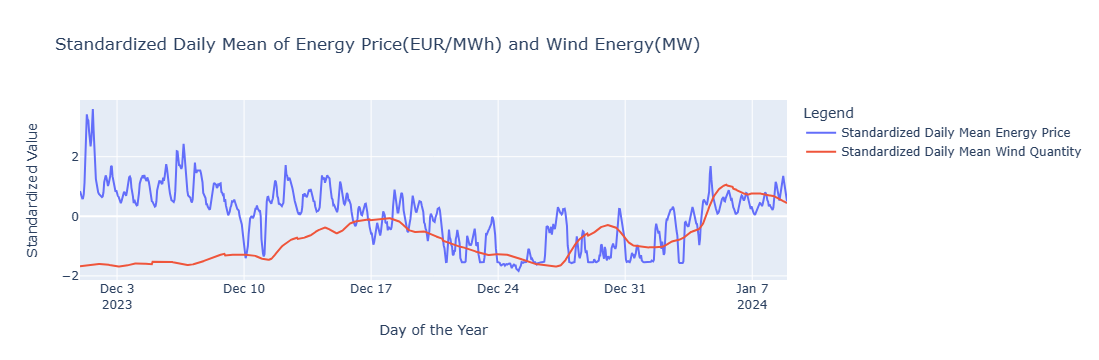

In [48]:
daily_prices = (
    prices_df.groupBy("actual_datetime")
    .agg(mean(col("price_amount")).alias("mean_price"))
    .orderBy("actual_datetime")
)

daily_wind = (
    wind_df.groupBy("actual_datetime")
    .agg(mean(col("quantity")).alias("mean_quantity"))
    .orderBy("actual_datetime")
)

# calculate mean and standard deviation for price
price_stats = daily_prices.agg(
    mean("mean_price").alias("mean"), stddev("mean_price").alias("stddev")
).first()
mean_price, stddev_price = price_stats["mean"], price_stats["stddev"]

# calculate mean and standard deviation for wind quantity
wind_stats = daily_wind.agg(
    mean("mean_quantity").alias("mean"), stddev("mean_quantity").alias("stddev")
).first()
mean_wind, stddev_wind = wind_stats["mean"], wind_stats["stddev"]

# standardize the data
daily_prices = daily_prices.withColumn(
    "std_mean_price", (col("mean_price") - mean_price) / stddev_price
)
daily_wind = daily_wind.withColumn(
    "std_mean_quantity", (col("mean_quantity") - mean_wind) / stddev_wind
)

std_daily_prices_data = daily_prices.collect()
std_daily_wind_data = daily_wind.collect()

days = [row["actual_datetime"] for row in std_daily_prices_data]
std_daily_mean_prices = [row["std_mean_price"] for row in std_daily_prices_data]
std_daily_mean_wind = [row["std_mean_quantity"] for row in std_daily_wind_data]

trace_std_daily_prices = go.Scatter(
    x=days,
    y=std_daily_mean_prices,
    mode="lines",
    name="Standardized Daily Mean Energy Price",
)
trace_std_daily_wind = go.Scatter(
    x=days,
    y=std_daily_mean_wind,
    mode="lines",
    name="Standardized Daily Mean Wind Quantity",
)

fig = go.Figure(data=[trace_std_daily_prices, trace_std_daily_wind])

fig.update_layout(
    title="Standardized Daily Mean of Energy Price (EUR/MWh) and Wind Energy (MW)",
    xaxis_title="Day of the Year",
    yaxis_title="Standardized Value",
    legend_title="Legend",
)

fig.show()

#### Wykres - zależność produkcji energii z wiatru od prędkości wiatru

In [193]:
# sczytanie danych ceny i wiatr
mean_daily_price = (
    prices_df.groupBy(date_trunc("day", "actual_datetime").alias("date"))
    .agg(
        mean("price_amount").alias("mean_price"),
    )
    .orderBy("date")
).collect()

total_daily_quantity = (
    wind_df.groupBy(date_trunc("day", "actual_datetime").alias("date"))
    .agg(
        mean("quantity").alias("total_quantity"),
    )
    .orderBy("date")
).collect()

mean_price_list = [row["mean_price"] for row in mean_daily_price][1:]
total_quantity_list = [row["total_quantity"] for row in total_daily_quantity][1:]

# zczytanie danych z HBase
ids = [row["date"].strftime("%Y%m%d") for row in mean_daily_price]
rows = table.rows(ids)

# zapisanie danych w formie ramki
df = (
    pd.DataFrame([{str(k, "utf8"): str(v, "utf8") for k, v in r[1].items()} for r in rows])
    .astype(float)
    .assign(
        wind_speed_total=lambda x: (x["agg:u10_avg_total"]**2 + x["agg:v10_avg_total"]**2).pow(1/2),
        wind_speed_north=lambda x: (x["agg:u10_avg_north"]**2 + x["agg:v10_avg_north"]**2).pow(1/2),
        wind_speed_south=lambda x: (x["agg:u10_avg_south"]**2 + x["agg:v10_avg_south"]**2).pow(1/2),
    )
)

df["mean_price"] = mean_price_list
df["total_quantity"] = total_quantity_list

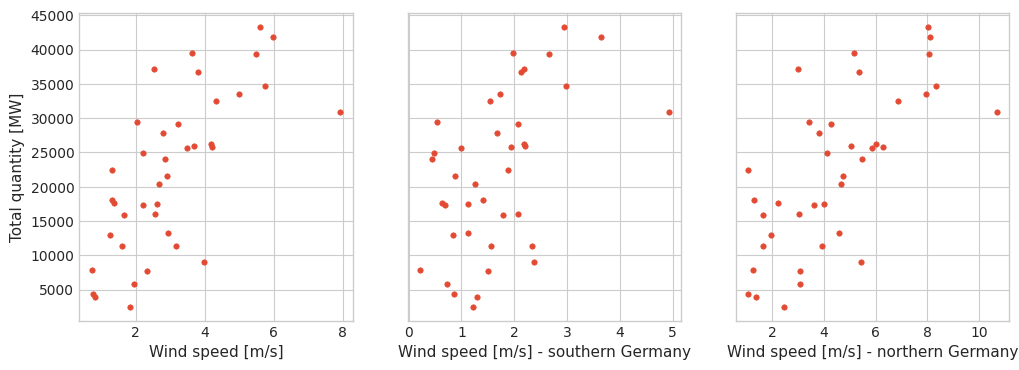

In [230]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

axs[0].scatter(df["wind_speed_total"], df["total_quantity"], s=15)
axs[1].scatter(df["wind_speed_south"], df["total_quantity"], s=15)
axs[2].scatter(df["wind_speed_north"], df["total_quantity"], s=15)
axs[0].set_ylabel("Total quantity [MW]", fontsize=11)
axs[0].set_xlabel("Wind speed [m/s]", fontsize=11)
axs[1].set_xlabel("Wind speed [m/s] - southern Germany", fontsize=11)
axs[2].set_xlabel("Wind speed [m/s] - northern Germany", fontsize=11)
plt.savefig("wind_speed_corr_plot.png", dpi=300, bbox_inches="tight")
plt.show()

In [198]:
# macierz korelacji
(
    df
        .loc[:, ["wind_speed_total", "wind_speed_north", "wind_speed_south", "mean_price", "total_quantity"]]
        .rename(columns={
            "wind_speed_total": "Wind speed",
            "wind_speed_north": "Wind speed - north",
            "wind_speed_south": "Wind speed - south",
            "total_quantity": "Total quantity",
            "mean_price": "Mean price",
        })
        .corr()
        .style
        .background_gradient(cmap="coolwarm", vmin=-1.5, vmax=1.5)
        .format(precision=2)
)

,Wind speed,Wind speed - north,Wind speed - south,Mean price,Total quantity
Wind speed,1.00,0.97,0.81,-0.71,0.71
Wind speed - north,0.97,1.00,0.67,-0.70,0.70
Wind speed - south,0.81,0.67,1.00,-0.55,0.52
Mean price,-0.71,-0.70,-0.55,1.00,-0.88
Total quantity,0.71,0.70,0.52,-0.88,1.00


## Widoki wsadowe

### Widok wsadowy - dane dzienne

In [227]:
# średnia cena, suma produkcji energii wiatrowej, średnia prędkość wiatru

mean_daily_price = (
    prices_df.groupBy(date_trunc("day", "actual_datetime").alias("date"))
    .agg(
        mean("price_amount").alias("mean_price"),
    )
    .orderBy("date")
)

total_daily_quantity = (
    wind_df.groupBy(date_trunc("day", "actual_datetime").alias("date"))
    .agg(
        mean("quantity").alias("total_quantity"),
    )
    .orderBy("date")
)

avg_wind_speed = (
    spark.sql("select valid_time, longitude, latitude, sqrt(u10*u10 + v10*v10) as wind_speed from gefs where time is not null;")
    .groupBy(date_trunc("day", "valid_time").alias("date"))
    .agg(
        mean("wind_speed").alias("avg_wind_speed"),
    )
    .orderBy("date")
)

daily_data = mean_daily_price.join(total_daily_quantity, on="date").join(avg_wind_speed, on="date").orderBy("date")
daily_data.createOrReplaceTempView("daily_data")

In [228]:
spark.sql("""
    SELECT * FROM daily_data LIMIT 10
""").show()

+-------------------+------------------+------------------+------------------+
|               date|        mean_price|    total_quantity|    avg_wind_speed|
+-------------------+------------------+------------------+------------------+
|2023-12-01 00:00:00|156.32583332061768|2539.8958333333335|2.1865103331468863|
|2023-12-02 00:00:00|116.53333282470703|4008.9791666666665|1.9503458452958466|
|2023-12-03 00:00:00|104.11666679382324| 7771.770833333333|3.0556860460029345|
|2023-12-04 00:00:00|111.63249969482422|       17367.78125|2.9495622301300233|
|2023-12-05 00:00:00|114.56416670481364|17575.541666666668|1.9472222612239896|
|2023-12-06 00:00:00| 129.7166665395101|        7897.40625|1.2818300350788112|
|2023-12-07 00:00:00|116.09749984741211| 5838.114583333333| 2.466828797988474|
|2023-12-08 00:00:00|104.00916703542073|           13336.5| 3.379572182383643|
|2023-12-09 00:00:00| 75.85999981562297|       21575.40625|3.3137457383100806|
|2023-12-10 00:00:00| 55.90374974409739|29432.239583